In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
## HELPER FUNCTIONS

def average(ls):
    return sum(ls)/len(ls)

In [4]:
def findOptimalCutLength(len_ls, loss_type = "portion_loss", min_cut_size = 100000, step_len = 100):
    min_len = min(len_ls)
    best_cut_len = 0
    
    if loss_type == "flat_loss":
        smallest_remainder = sum(len_ls)
        for i in range(min_len, min_cut_size , -step_len):
            sum_remainder = 0

            for len_int in len_ls:
                sum_remainder += len_int % i

            if sum_remainder < smallest_remainder:
                smallest_remainder = sum_remainder
                best_cut_len = i
                
        print("flat_loss:", smallest_remainder, "/", sum(len_ls))
        print("portion_loss:", smallest_remainder / sum(len_ls))
                
    if loss_type == "portion_loss":
        smallest_portion_loss = 1
        
        for i in range(min_len, min_cut_size , -step_len):
            portion_loss_ls = []
            for len_int in len_ls:
                remainder = len_int % i
                portion_loss_ls.append(remainder / len_int)
                
            avg_portion_loss = average(portion_loss_ls)
            if avg_portion_loss < smallest_portion_loss:
                smallest_portion_loss = avg_portion_loss
                best_cut_len = i
        print("avg_portion_loss:", smallest_portion_loss)
            
    return best_cut_len

In [5]:
def cutAndPrepareSong(song, cut_len):
    if cut_len == None:
        cut_len = 100000
        
    start = 0
    end = len(song)

    list_matrices = []
    
    while start + cut_len < end:
        melspect = librosa.feature.melspectrogram(song[start:start+cut_len])
        list_matrices.append(melspect)
        start += cut_len
    return list_matrices

In [6]:
music_ext = ['mp3','m4a']

def loadSongs(music_folder, genre):
    len_ls = []
    song_ls = []
    genre_ls = []
    best_cut_len = None
    for root, directories, file_ls in os.walk(music_folder):
        for file_name in file_ls:
            if file_name.split('.')[-1].lower() not in music_ext:
                continue
            file_path = root + "\\" + file_name
            print("Currently looking at", file_path)
            
            y,sr = librosa.load(file_path)
            song_ls.append(y)
            len_ls.append(len(y))
            genre_ls.append(genre)
    return song_ls, genre_ls, len_ls
            
    
def addSongs(song_ls, genre_ls, cut_len = 100000):    
    all_tracks = []
    all_genre = []
    for i in range(len(song_ls)):
        song_pieces = cutAndPrepareSong(song_ls[i], cut_len = cut_len)
        all_tracks += song_pieces
        all_genre += ([int(genre_ls[i])]*len(song_pieces))
    return all_tracks,all_genre      

In [7]:
all_track_pieces = []
all_genre_of_track_pieces = []

song_ls_touhou, genre_ls_touhou, len_ls_touhou = loadSongs("D:\Music\TESTING FOLDER\Touhou", 0)
song_ls_nontouhou, genre_ls_nontouhou, len_ls_nontouhou = loadSongs("D:\Music\TESTING FOLDER\\Not_Touhou", 1)
best_cut_len = findOptimalCutLength(len_ls_touhou + len_ls_nontouhou, loss_type="portion_loss",step_len=1)

all_track_pieces, all_genre_of_track_pieces = addSongs(song_ls_touhou + song_ls_nontouhou, 
                                                       genre_ls_touhou + genre_ls_nontouhou, 
                                                       cut_len=best_cut_len)

Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocal】Sympathy【CielArc】.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocal】はかなき夢ぞ命なりける【TsuBaKi】.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocal】メレンゲ‐白い恋の唄‐【GET IN THE RING】.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocal】二人だけの幻想世界【TUMENECO】.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocal】月に憑かれたウサギ（咲子ver ）_少女理論観測所【狂気の瞳　～ Invisible Full Moon】.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocalアレンジ】 「C.E.L」 【Sun Flower Field】ラストリモート.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocalアレンジ】 「GOLD」 【ZYTOKINE】御伽の国の鬼が島　～ Missing Power.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocalアレンジ】 「MOON LIGHT DANCE」【TatshMusicCircle】狂気の瞳　～ Invisible Full Moon.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocalアレンジ】 「overflow」 【Silver Forest】ラストリモート.mp3
Currently looking at D:\Music\TESTING FOLDER\Touhou\【東方Vocalアレンジ】 「PERFECT AIM」 

In [8]:
len(all_track_pieces), len(all_genre_of_track_pieces)

(4233, 4233)

In [9]:
random_state = None

X_train, X_test, y_train, y_test = train_test_split(np.array(all_track_pieces), 
                                                    np.array(all_genre_of_track_pieces),
                                                    train_size=0.6,
                                                    stratify=np.array(all_genre_of_track_pieces),
                                                    random_state=random_state)

X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test,
                                                train_size=0.5,
                                                random_state=random_state)

In [10]:
print("Train size:",len(X_train),len(y_train))
print("Val size:",len(X_val),len(y_val))
print("Test size:",len(X_test),len(y_test))

Train size: 2539 2539
Val size: 847 847
Test size: 847 847


In [11]:
input_shape = (len(all_track_pieces[0]),len(all_track_pieces[0][0]))

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape[0],input_shape[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 195, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 97, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 95, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 47, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 45, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 80640)             0

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer= 'Adam', #'Adam', 'RMSprop'
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=10)

Epoch 1/10
80/80 [==============================] - 12s 94ms/step - loss: 4.3819 - accuracy: 0.5735 - precision: 0.5499 - recall: 0.3832 - auc: 0.6100 - val_loss: 0.6538 - val_accuracy: 0.6659 - val_precision: 0.6540 - val_recall: 0.5081 - val_auc: 0.7124
Epoch 2/10
80/80 [==============================] - 6s 76ms/step - loss: 0.6113 - accuracy: 0.7050 - precision: 0.7044 - recall: 0.6143 - auc: 0.7538 - val_loss: 0.6627 - val_accuracy: 0.6895 - val_precision: 0.6764 - val_recall: 0.5618 - val_auc: 0.7287
Epoch 3/10
80/80 [==============================] - 6s 70ms/step - loss: 0.5281 - accuracy: 0.7444 - precision: 0.7245 - recall: 0.7139 - auc: 0.8174 - val_loss: 0.6704 - val_accuracy: 0.7084 - val_precision: 0.7376 - val_recall: 0.5215 - val_auc: 0.7703
Epoch 4/10
80/80 [==============================] - 6s 70ms/step - loss: 0.4084 - accuracy: 0.8145 - precision: 0.7900 - recall: 0.8110 - auc: 0.8922 - val_loss: 0.7147 - val_accuracy: 0.7155 - val_precision: 0.7673 - val_recall: 0.50

27/27 [==============================] - 1s 27ms/step - loss: 1.6734 - accuracy: 0.7296 - precision: 0.7566 - recall: 0.6386 - auc: 0.7798


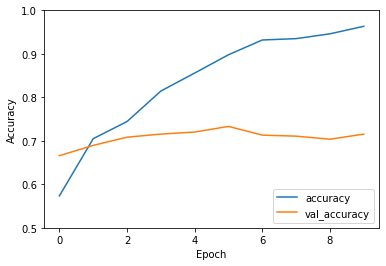

In [14]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

result = model.predict(X_test)

loss, accuracy, precision, recall, auc = model.evaluate(X_test,  y_test)

In [15]:
for i, prediction in enumerate(result):
    if prediction[0] > 0.5:
        print(i,prediction[0],y_test[i])

1 0.9999838 1
6 0.72249496 0
8 0.9568733 1
10 0.9812144 0
12 0.9488713 1
17 0.6644257 0
18 0.9739227 1
23 0.9606242 0
24 0.7431486 0
25 0.8335998 1
26 0.544465 1
27 0.6166982 1
28 0.98654616 1
29 0.6535273 1
33 0.99999976 1
35 0.99949586 1
36 0.9953015 1
40 0.9723361 0
42 0.792253 1
44 0.99999297 1
47 0.75867695 1
49 0.9999999 1
52 1.0 1
54 0.9994603 1
56 0.8837708 0
59 0.8697985 1
60 0.99994314 1
61 0.9999988 1
68 0.99962115 1
70 0.9990011 1
71 0.84994304 1
74 0.99773526 1
75 0.82897216 0
85 0.6701013 1
86 0.9919478 1
89 0.99541324 1
93 0.9680227 1
94 0.9604485 1
96 0.70572615 1
98 0.5296636 1
99 0.76537925 1
100 0.9224269 1
101 0.74755853 1
104 0.99995553 1
106 0.9012064 1
108 0.7050608 1
109 0.6698379 0
111 0.7405376 0
113 0.99854964 0
115 0.8271539 0
118 0.9907789 1
119 0.6930683 1
123 0.8838638 1
125 0.9999988 1
128 0.9766848 1
130 0.97238785 0
131 0.9433252 1
132 0.8362899 1
133 0.53729177 0
136 0.99106884 1
138 0.98296195 1
146 0.9749176 1
147 0.998453 1
149 0.99991333 0
154 0.9